<a href="https://colab.research.google.com/github/bassoline/DeepLearning/blob/main/ClassificationMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline 
import numpy as np 
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 
import warnings 
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (8,8)

Input (X) shape: (100, 2)
Labels (Y) shape: (100,)


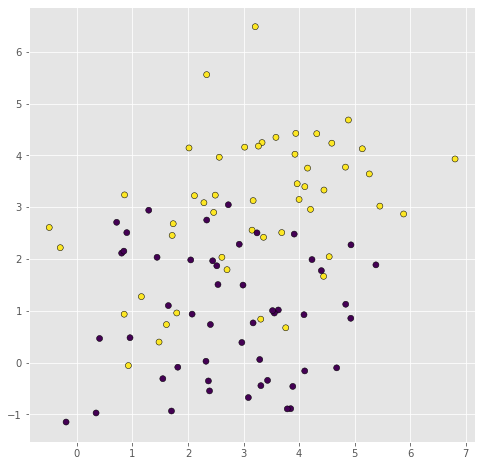

In [25]:
# generate dataset 
seed = 42 
randomGenerator = np.random.RandomState(seed)
torch.manual_seed(seed)

# generate two class classification data 
X, Y = make_classification(
    n_features = 2, 
    n_redundant = 0, 
    n_informative = 2, 
    random_state = seed, 
    n_clusters_per_class = 1
)

# add some noise 
X += 4 * randomGenerator.uniform(size = X.shape)

print('Input (X) shape: {}'.format(X.shape))
print('Labels (Y) shape: {}'.format(Y.shape))

plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k')

# divide data into test and training data 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = seed)
# convert from numpy to torch 
x_train, y_train = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float().reshape(-1,1)
x_test, y_test = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float().reshape(-1,1)

In [26]:
class LogisticRegression(nn.Module): 
  def __init__(self, n_features):
    super().__init__()
    # linear layer (WX+B)
    self.linear = nn.Linear(n_features, 1, bias=True)
  
  def forward(self, x): 
    # calculate WX + B 
    x = self.linear(x)
    # sigmoid activation for prediction
    predictions = torch.sigmoid(x)
    return predictions

In [27]:
class Trainer: 
  def __init__(self, model, criterion, optimizer, epoch_num): 
    self.model = model
    # fancy way to say loss function
    self.criterion = criterion 
    self.optimizer = optimizer 
    self.epoch_num = epoch_num

  def fit(self, inputs, targets): 
    # set model in train state 
    self.model.train()
    
    for _ in range(self.epoch_num): 
      # set gradient to zero
      self.optimizer.zero_grad()
      # forward pass w/ predictions
      preds = self.model(inputs)
      # get the loss 
      loss = self.criterion(preds, targets)
      # calculate gradients
      loss.backward()
      # update params 
      self.optimizer.step()
  
  def predict(self, inputs): 
    # set model in evaluation state 
    self.model.eval()
    # turn off code for backprop
    with torch.no_grad(): 
      preds = self.model(inputs)
      
    return preds


In [28]:
# initalize model, optimizer, loss function
epoch_num = 200
learning_rate = 0.01
log_regression = LogisticRegression(n_features=2)
# binary cross entropy loss 
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(log_regression.parameters(), lr=learning_rate)
trainer = Trainer(log_regression, criterion, optimizer, epoch_num)

# train the model 
trainer.fit(x_train, y_train)

# predict with the model 
y_predicted = trainer.predict(x_test)